In [1]:
import sys
sys.path.append("..")

from src.usecase.consolidate_feats_and_annot import read_tse_bi
from src.usecase.fetch_database import create_df_from_file_pattern
import pandas as pd
import os
import seaborn as sns
import re

In [2]:
DATASET_PATIENT_PATTERN = r"[P][A][T][_][0-9]*"
DATASET_EXAM_PATTERN = r"[E][E][G][_][0-9]*"
ANNOTATION_FILE_PATTERN = "*.tse_bi"

In [3]:
df = create_df_from_file_pattern(
    data_folder_path='../output/res-comp-v0_6',
    file_pattern=ANNOTATION_FILE_PATTERN,
    file_label='ecg_qc',
    patient_pattern=DATASET_PATIENT_PATTERN,
    exam_pattern=DATASET_EXAM_PATTERN)
print(df)

                                      ecg_qc_file_path  exam_id patient_id
0    ../output/res-comp-v0_6/PAT_22/qc_qrs_EEG_304_...  EEG_304     PAT_22
1    ../output/res-comp-v0_6/PAT_22/qc_qrs_EEG_311_...  EEG_311     PAT_22
2    ../output/res-comp-v0_6/PAT_22/qc_qrs_EEG_304_...  EEG_304     PAT_22
3    ../output/res-comp-v0_6/PAT_22/qc_qrs_EEG_311_...  EEG_311     PAT_22
4    ../output/res-comp-v0_6/PAT_22/qc_qrs_EEG_304_...  EEG_304     PAT_22
..                                                 ...      ...        ...
401  ../output/res-comp-v0_6/PAT_9/qc_qrs_EEG_103_s...  EEG_103      PAT_9
402  ../output/res-comp-v0_6/PAT_9/qc_qrs_EEG_103_s...  EEG_103      PAT_9
403  ../output/res-comp-v0_6/PAT_9/qc_qrs_EEG_103_s...  EEG_103      PAT_9
404  ../output/res-comp-v0_6/PAT_9/qc_qrs_EEG_103_s...  EEG_103      PAT_9
405  ../output/res-comp-v0_6/PAT_9/qc_qrs_EEG_103_s...  EEG_103      PAT_9

[406 rows x 3 columns]


In [86]:
def compute_stats_files(tse_bi_file):
    
    df = read_tse_bi(tse_bi_file)
    df['length'] = df['end'] - df['start']
    total_length = df['length'].sum()
    total_noise = df[df['annotation'] == 'noisy']['length'].sum()
    total_clean = df[df['annotation'] == 'clean']['length'].sum()
    small_chunks = df[(df['annotation'] == 'noisy') & (df['length'].dt.seconds <= 8)].shape[0]
    big_chunks = df[(df['annotation'] == 'noisy') & (df['length'].dt.seconds >= 8)].shape[0]
    very_big_chunks = df[(df['annotation'] == 'noisy') & (df['length'].dt.seconds >= 8)].shape[0]
    # df[['ratio_clean', 'small_chunks']].fillna(0)
    if str(total_noise) == "NaT":
        total_noise = pd.Timedelta(seconds=0)
    if str(total_clean) == "NaT":
        total_clean = pd.Timedelta(seconds=0)

    return total_length, total_noise, total_clean, small_chunks, big_chunks, very_big_chunks

In [87]:
for i in df.index:
    total_length, total_noise, total_clean, small_chunks, big_chunks, very_big_chunks = compute_stats_files(df.loc[i, 'ecg_qc_file_path'])
    df.loc[i, 'total_length'] = total_length
    df.loc[i, 'total_noise'] = total_noise
    df.loc[i, 'total_clean'] = total_clean
    df.loc[i, 'small_chunks'] = small_chunks
    df.loc[i, 'big_chunks'] = big_chunks
    df.loc[i, 'very_big_chunks'] = very_big_chunks
    

df[['total_length', 'total_noise', 'total_clean']].fillna(pd.Timedelta(seconds=0), inplace=True)
df['ratio_clean'] = df['total_clean'] / df['total_length']
df['ratio_small_chunks'] = df['small_chunks']*4 / df['total_length'].dt.seconds

df.head()

/home/aura-alexis/github/seizure_detection_pipeline/env/lib64/python3.6/site-packages/pandas/core/frame.py:4327: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,


,ecg_qc_file_path,exam_id,patient_id,total_length,total_noise,total_clean,small_chunks,big_chunks,very_big_chunks,ratio_clean,ratio_small_chunks
0,../output/res-comp-v0_6/PAT_22/qc_qrs_EEG_304_...,EEG_304,PAT_22,0 days 01:27:40,0 days 01:27:40,0 days 00:00:00,0.0,1.0,1.0,0.000000,0.000000
1,../output/res-comp-v0_6/PAT_22/qc_qrs_EEG_311_...,EEG_311,PAT_22,0 days 00:32:20,0 days 00:32:20,0 days 00:00:00,0.0,1.0,1.0,0.000000,0.000000
2,../output/res-comp-v0_6/PAT_22/qc_qrs_EEG_304_...,EEG_304,PAT_22,0 days 00:03:34,0 days 00:00:00,0 days 00:03:34,0.0,0.0,0.0,1.000000,0.000000
3,../output/res-comp-v0_6/PAT_22/qc_qrs_EEG_311_...,EEG_311,PAT_22,0 days 00:17:50,0 days 00:00:14,0 days 00:17:36,3.0,0.0,0.0,0.986916,0.011215
4,../output/res-comp-v0_6/PAT_22/qc_qrs_EEG_304_...,EEG_304,PAT_22,0 days 00:07:32,0 days 00:01:04,0 days 00:06:28,19.0,1.0,1.0,0.858407,0.168142


In [88]:
df[df['ratio_clean'].isna()]

,ecg_qc_file_path,exam_id,patient_id,total_length,total_noise,total_clean,small_chunks,big_chunks,very_big_chunks,ratio_clean,ratio_small_chunks


In [89]:
df[df['very_big_chunks'] <= 0]['total_length'].dt.seconds.sum() / df['total_length'].dt.seconds.sum()

0.2591354284314253

In [90]:
df[df['very_big_chunks'] >= 1][['total_length', 'very_big_chunks']]

,total_length,very_big_chunks
0,0 days 01:27:40,1.0
1,0 days 00:32:20,1.0
4,0 days 00:07:32,1.0
6,0 days 00:46:12,2.0
21,0 days 00:01:42,1.0
...,...,...
345,0 days 06:15:48,5.0
349,0 days 16:28:22,106.0
350,0 days 00:30:30,3.0
363,0 days 00:16:18,2.0


In [54]:
# Top noisy

df.sort_values('ratio_clean', ascending=False)

,ecg_qc_file_path,exam_id,patient_id,total_length,total_noise,total_clean,small_chunks,big_chunks,very_big_chunks,ratio_clean,ratio_small_chunks
203,../output/res-comp-v0_6/PAT_49/qc_qrs_EEG_638_...,EEG_638,PAT_49,0 days 00:00:28,0 days 00:00:00,0 days 00:00:28,0.0,0.0,0.0,1.0,0.0
247,../output/res-comp-v0_6/PAT_52/qc_qrs_EEG_714_...,EEG_714,PAT_52,0 days 00:00:54,0 days 00:00:00,0 days 00:00:54,0.0,0.0,0.0,1.0,0.0
255,../output/res-comp-v0_6/PAT_52/qc_qrs_EEG_689_...,EEG_689,PAT_52,0 days 00:01:26,0 days 00:00:00,0 days 00:01:26,0.0,0.0,0.0,1.0,0.0
253,../output/res-comp-v0_6/PAT_52/qc_qrs_EEG_714_...,EEG_714,PAT_52,0 days 00:14:52,0 days 00:00:00,0 days 00:14:52,0.0,0.0,0.0,1.0,0.0
252,../output/res-comp-v0_6/PAT_52/qc_qrs_EEG_689_...,EEG_689,PAT_52,0 days 00:00:50,0 days 00:00:00,0 days 00:00:50,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
118,../output/res-comp-v0_6/PAT_44/qc_qrs_EEG_573_...,EEG_573,PAT_44,0 days 00:15:22,0 days 00:15:22,0 days 00:00:00,0.0,1.0,1.0,0.0,0.0
1,../output/res-comp-v0_6/PAT_22/qc_qrs_EEG_311_...,EEG_311,PAT_22,0 days 00:32:20,0 days 00:32:20,0 days 00:00:00,0.0,1.0,1.0,0.0,0.0
134,../output/res-comp-v0_6/PAT_46/qc_qrs_EEG_593_...,EEG_593,PAT_46,0 days 00:06:28,0 days 00:06:28,0 days 00:00:00,0.0,1.0,1.0,0.0,0.0
136,../output/res-comp-v0_6/PAT_46/qc_qrs_EEG_593_...,EEG_593,PAT_46,0 days 00:01:22,0 days 00:01:22,0 days 00:00:00,0.0,1.0,1.0,0.0,0.0


In [37]:
# Top clean
df.sort_values('ratio_clean', ascending=False)

,ecg_qc_file_path,exam_id,patient_id,total_length,total_noise,total_clean,small_chunks,big_chunks,very_big_chunks,ratio_clean,ratio_small_chunks
203,../output/res-comp-v0_6/PAT_49/qc_qrs_EEG_638_...,EEG_638,PAT_49,0 days 00:00:28,0 days 00:00:00,0 days 00:00:28,0.0,0.0,0.0,1.0,0.0
247,../output/res-comp-v0_6/PAT_52/qc_qrs_EEG_714_...,EEG_714,PAT_52,0 days 00:00:54,0 days 00:00:00,0 days 00:00:54,0.0,0.0,0.0,1.0,0.0
255,../output/res-comp-v0_6/PAT_52/qc_qrs_EEG_689_...,EEG_689,PAT_52,0 days 00:01:26,0 days 00:00:00,0 days 00:01:26,0.0,0.0,0.0,1.0,0.0
253,../output/res-comp-v0_6/PAT_52/qc_qrs_EEG_714_...,EEG_714,PAT_52,0 days 00:14:52,0 days 00:00:00,0 days 00:14:52,0.0,0.0,0.0,1.0,0.0
252,../output/res-comp-v0_6/PAT_52/qc_qrs_EEG_689_...,EEG_689,PAT_52,0 days 00:00:50,0 days 00:00:00,0 days 00:00:50,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
118,../output/res-comp-v0_6/PAT_44/qc_qrs_EEG_573_...,EEG_573,PAT_44,0 days 00:15:22,0 days 00:15:22,0 days 00:00:00,0.0,1.0,1.0,0.0,0.0
1,../output/res-comp-v0_6/PAT_22/qc_qrs_EEG_311_...,EEG_311,PAT_22,0 days 00:32:20,0 days 00:32:20,0 days 00:00:00,0.0,1.0,1.0,0.0,0.0
134,../output/res-comp-v0_6/PAT_46/qc_qrs_EEG_593_...,EEG_593,PAT_46,0 days 00:06:28,0 days 00:06:28,0 days 00:00:00,0.0,1.0,1.0,0.0,0.0
136,../output/res-comp-v0_6/PAT_46/qc_qrs_EEG_593_...,EEG_593,PAT_46,0 days 00:01:22,0 days 00:01:22,0 days 00:00:00,0.0,1.0,1.0,0.0,0.0


In [12]:
# Ratio clean/noise
df['total_clean'].dt.seconds.sum() / df['total_length'].dt.seconds.sum()

0.9312250885904998

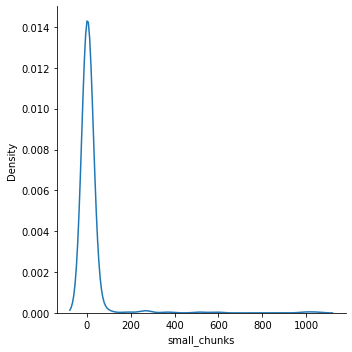

In [13]:
# Small chunks are scarse
sns.displot(df['small_chunks'], kind='kde')

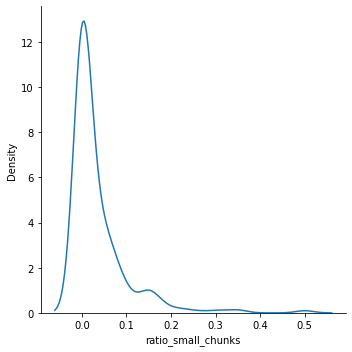

In [14]:
# Small chunks are scarse
sns.displot(df['ratio_small_chunks'], kind='kde')

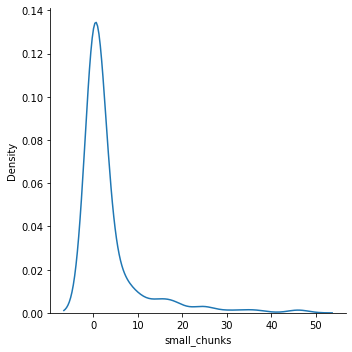

In [15]:
# They are quite rare
sns.displot(df[df['small_chunks'] <= 50]['small_chunks'], kind='kde')

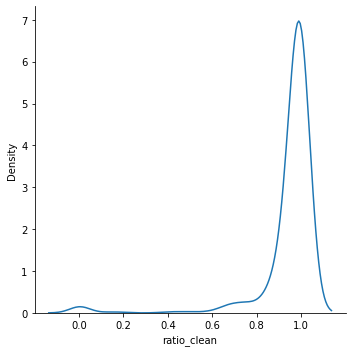

In [16]:
sns.displot(df['ratio_clean'], kind='kde')

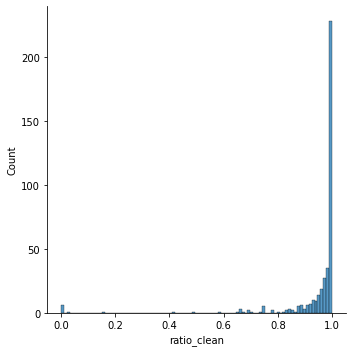

In [17]:
sns.displot(df['ratio_clean'])

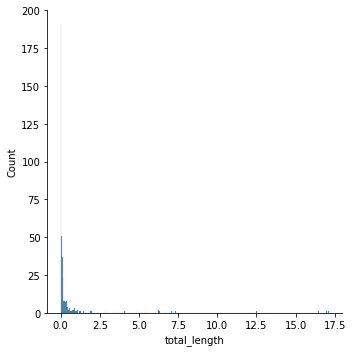

In [18]:
sns.displot(df['total_length'].dt.seconds/3600)

In [22]:
# with good quality
(df[df['ratio_clean'] > 0.8]).shape[0] / df.shape[0]

0.9310344827586207

In [24]:
# % for goog quality length
df[df['ratio_clean'] > 0.9]['total_length'].dt.seconds.sum() / df['total_length'].dt.seconds.sum()

0.8608875184501293

In [26]:
df.columns

Index(['ecg_qc_file_path', 'exam_id', 'patient_id', 'total_length',
       'total_noise', 'total_clean', 'small_chunks', 'big_chunks',
       'very_big_chunks', 'ratio_clean', 'ratio_small_chunks'],
      dtype='object')

In [64]:
# % for goog quality length
df[df['very_big_chunks'] <= 0]['total_length'].dt.seconds.sum() / df['total_length'].dt.seconds.sum()

0.8530562975445641

In [63]:
(df[df['very_big_chunks'] <= 0]).shape[0] / df.shape[0]

0.9630541871921182

## Taking only good quality segments

In [91]:
df_clean = df[df['very_big_chunks'] == 0]
df_clean.head()

,ecg_qc_file_path,exam_id,patient_id,total_length,total_noise,total_clean,small_chunks,big_chunks,very_big_chunks,ratio_clean,ratio_small_chunks
2,../output/res-comp-v0_6/PAT_22/qc_qrs_EEG_304_...,EEG_304,PAT_22,0 days 00:03:34,0 days 00:00:00,0 days 00:03:34,0.0,0.0,0.0,1.000000,0.000000
3,../output/res-comp-v0_6/PAT_22/qc_qrs_EEG_311_...,EEG_311,PAT_22,0 days 00:17:50,0 days 00:00:14,0 days 00:17:36,3.0,0.0,0.0,0.986916,0.011215
5,../output/res-comp-v0_6/PAT_22/qc_qrs_EEG_311_...,EEG_311,PAT_22,0 days 00:03:14,0 days 00:00:22,0 days 00:02:52,8.0,0.0,0.0,0.886598,0.164948
7,../output/res-comp-v0_6/PAT_22/qc_qrs_EEG_311_...,EEG_311,PAT_22,0 days 00:12:06,0 days 00:00:00,0 days 00:12:06,0.0,0.0,0.0,1.000000,0.000000
8,../output/res-comp-v0_6/PAT_22/qc_qrs_EEG_304_...,EEG_304,PAT_22,0 days 00:03:06,0 days 00:00:00,0 days 00:03:06,0.0,0.0,0.0,1.000000,0.000000


In [92]:
df_clean.shape

(328, 11)

In [ ]:
df_clean['cons'] = df_clean['ecg_qc_file_path'].apply(lambda x: x.replace('res-comp-v0_6', 'cons-v0_6').replace('qc_qrs', 'cons').replace('tse_bi', 'csv').replace('cons_', 'cons_{}_Annotations_'.format(re.search(r'PAT_[0-9]*', x).group(0))))
df_clean.head()

/home/aura-alexis/github/seizure_detection_pipeline/env/lib64/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,ecg_qc_file_path,exam_id,patient_id,total_length,total_noise,total_clean,small_chunks,ratio_clean,ratio_small_chunks,cons
1,../output/res-comp-v0_6/PAT_12/qc_qrs_EEG_297_...,EEG_297,PAT_12,0 days 00:05:42,0 days 00:00:04,0 days 00:05:38,2.0,0.988304,0.023392,../output/cons-v0_6/PAT_12/cons_PAT_12_Annotat...
2,../output/res-comp-v0_6/PAT_12/qc_qrs_EEG_299_...,EEG_299,PAT_12,0 days 00:02:08,0 days 00:00:00,0 days 00:02:08,0.0,1.000000,0.000000,../output/cons-v0_6/PAT_12/cons_PAT_12_Annotat...
3,../output/res-comp-v0_6/PAT_12/qc_qrs_EEG_300_...,EEG_300,PAT_12,0 days 00:33:30,0 days 00:00:32,0 days 00:32:58,8.0,0.984080,0.015920,../output/cons-v0_6/PAT_12/cons_PAT_12_Annotat...
10,../output/res-comp-v0_6/PAT_17/qc_qrs_EEG_259_...,EEG_259,PAT_17,0 days 00:00:22,0 days 00:00:00,0 days 00:00:22,0.0,1.000000,0.000000,../output/cons-v0_6/PAT_17/cons_PAT_17_Annotat...
11,../output/res-comp-v0_6/PAT_17/qc_qrs_EEG_259_...,EEG_259,PAT_17,0 days 00:00:18,0 days 00:00:00,0 days 00:00:18,0.0,1.000000,0.000000,../output/cons-v0_6/PAT_17/cons_PAT_17_Annotat...


In [ ]:
import shutil

for src in df_clean['cons'].values:
    dst = src.replace('cons-v0_6', 'cons-v0_6_clean_small_chunks')
    os.makedirs(os.path.dirname(dst), exist_ok=True)
    shutil.copyfile(src, dst)